### Movie Recommendations

We will apply collaborative filtering learning algorithm and apply it to a dataset of movie ratings.<br>

In [25]:
import matplotlib.pyplot as plt  # plotting library
import numpy as np               # N- dim object array 
import scipy.io 
import scipy.optimize as opt
import seaborn as sns
# inline plotting of graphs
%matplotlib inline               

In [26]:
data = scipy.io.loadmat("movies.mat")

Y is a 1682 x 943 matrix, containing ratings (1 - 5) of 1682 movies on 943 users. Each cell represents the rating given by user j to movie i  <br>
R is a 1682 x 943 matrix, where R(i,j) = 1 if and only if user j gave a rating to movie i else 0

In [27]:
Y = data['Y']
R = data['R']

In [28]:
print('Average rating for movie 1 (Toy Story): %.2f'%np.mean(Y[0, R[0, :]==1]),'/ 5');

Average rating for movie 1 (Toy Story): 3.88 / 5


#### We can visualize the ratings matrix by plotting it

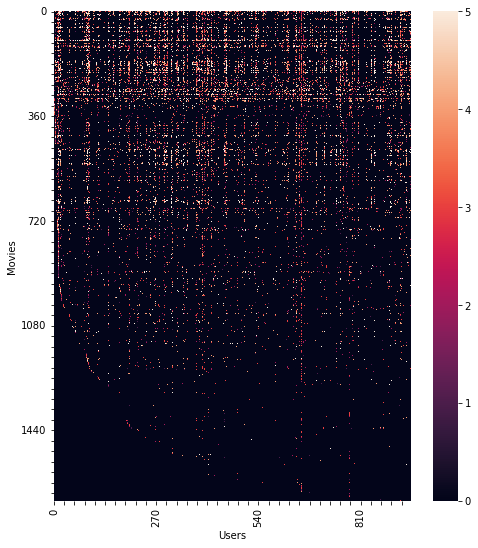

In [29]:
plt.figure(figsize=(8,9))

ax = sns.heatmap(Y,cmap=  "rocket") 

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)
for ind, label in enumerate(ax.get_yticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

plt.xlabel("Users")
plt.ylabel("Movies")
plt.show()

#### The Visualisation shows the distribution of the ratings

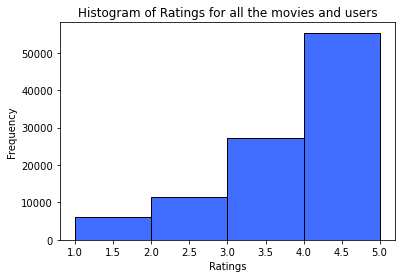

In [30]:
Y_flatten = Y[Y!=0].flatten()
x = Y_flatten.shape[0]  
sns.set_palette("bright")
sns.histplot(np.reshape(Y_flatten,x),bins =4 )
plt.xlabel("Ratings")
plt.ylabel("Frequency")
plt.title("Histogram of Ratings for all the movies and users")
plt.show()

In [31]:
a = Y.flatten().shape[0]
b = Y_flatten.shape[0]
print("Total Expected Ratings",a)
print("Number of unrated movies by all the users",a-b)
print("Number of ratings given by users",b)

Total Expected Ratings 1586126
Number of unrated movies by all the users 1486126
Number of ratings given by users 100000


<ul>
<li>Total Expected Ratings 1587808</li>
<li>Number of unrated movies by all the users 1487808</li>
<li>Number of ratings given by users 100000</li>
</ul>

#### Collaborative filtering learning algorithm

Cost Function

In [32]:
def costFunction(params_data, Y, R, num_users, num_movies, num_features, lambda_):
    X = np.reshape(params_data[:num_movies*num_features], (num_movies, num_features))
    Theta = np.reshape(params_data[(num_movies*num_features):], (num_users, num_features))
    J = (1/2)*np.sum(np.square((X.dot(Theta.T)-Y)*R)) + (lambda_/2)*np.sum(np.square(Theta)) + (lambda_/2)*np.sum(np.square(X))
    return J


Gradient

In [33]:
def gradient(params_data, Y, R, num_users, num_movies, num_features, lambda_):
    X = np.reshape(params_data[:num_movies*num_features], (num_movies, num_features))
    Theta = np.reshape(params_data[(num_movies*num_features):], (num_users, num_features))
    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    X_grad = ((np.dot(X,(Theta.T))-Y)*R).dot(Theta) + lambda_*X
    Theta_grad = ((np.dot(X,Theta.T)-Y)*R).T.dot(X) + lambda_*Theta
    grad = np.concatenate((X_grad.flatten(), Theta_grad.flatten()))
    return grad

Combining both in one function.

In [34]:

def cofiCostFunc(params_data, Y, R, num_users, num_movies, num_features, lambda_):
    
    J =costFunction(params_data, Y, R, num_users, num_movies, num_features, lambda_)
    grad = gradient(params_data, Y, R, num_users, num_movies, num_features, lambda_)
    return J, grad



### Learning Movie Recommendations

In [35]:
def loadMovieList(change = True):
    movie_ids = {}
    with open('movie_ids.txt','r') as f:
        for line in f.readlines():
            ids = line.split()[0]
            title = ' '.join(line.split()[1:])
            movie_ids[ids] = title
            
    # visualize the first ten titles and ids
    if change == True :
        print("The first ten titles in the movies list")
        for i in range(1,11):
            print(i, movie_ids[str(i)])
    return movie_ids

I add my own ratings to a few movies so that the recommender system can use this to predict ratings for other movies

In [36]:
movieList = loadMovieList()
my_ratings = np.zeros((1682,1))
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354]= 5

The first ten titles in the movies list
1 Toy Story (1995)
2 GoldenEye (1995)
3 Four Rooms (1995)
4 Get Shorty (1995)
5 Copycat (1995)
6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
7 Twelve Monkeys (1995)
8 Babe (1995)
9 Dead Man Walking (1995)
10 Richard III (1995)


In [37]:
print("My original ratings:")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print("Rated ", int(my_ratings[i]),movieList[str(i+1)])

My original ratings:
Rated  4 Toy Story (1995)
Rated  3 Twelve Monkeys (1995)
Rated  5 Usual Suspects, The (1995)
Rated  4 Outbreak (1995)
Rated  5 Shawshank Redemption, The (1994)
Rated  3 While You Were Sleeping (1995)
Rated  5 Forrest Gump (1994)
Rated  2 Silence of the Lambs, The (1991)
Rated  4 Alien (1979)
Rated  5 Die Hard 2 (1990)
Rated  5 Sphere (1998)


I add my own rating ratings to the ratings matrix.

In [38]:
data = scipy.io.loadmat("movies.mat")
Y = data['Y']
R = data['R']

Y = np.concatenate((my_ratings,Y),axis=1)
R = np.concatenate(((my_ratings!= 0),R),axis=1)

In [39]:
def normalizeRatings(Y, R):
    m = Y.shape[0]
    Ymean = np.zeros((m,1))
    Ynorm = np.zeros(Y.shape)
    for i in range(m):
        idx = R[i,:]==1
        Ymean[i] = np.mean(Y[i,idx])
        Ynorm[i,idx] = Y[i,idx] - Ymean[i]

    return Ynorm, Ymean

In [40]:
Ynorm, Ymean = normalizeRatings(Y, R)
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10

X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)
initial_parameters = np.concatenate((X.flatten(), Theta.flatten()))
lambdaa = 10

I train the model on the data by altering the cost function using the gradient to change the theta values.

In [51]:
theta = opt.fmin_cg(f = costFunction, x0 = initial_parameters, fprime=gradient, args=(Ynorm, R, num_users, num_movies, num_features, lambdaa), maxiter=150,full_output = True)

         Current function value: 38951.863490
         Iterations: 150
         Function evaluations: 224
         Gradient evaluations: 224


In [52]:

X = np.reshape(theta[0][:num_movies*num_features],(num_movies,num_features))
Theta = np.reshape(theta[0][num_movies*num_features:],(num_users,num_features))

Finding the predictions for all users

In [53]:
p = np.matmul( X,(Theta.T))

Checking the predictions for myself and giving the Top 10 recommendation 

In [54]:

my_predictions = p[:,0] + np.reshape(Ymean,(1682))

In [56]:

movieList = loadMovieList(False)

# Returns the indices that would sort an array. For example, if the input array is [3,1,2], the output is [1,2,0]
ix = my_predictions.argsort()[::-1]

for i in range(10):
    j = ix[i]
    if i==0:
        print("Top recommendations: ")
    print("%.1f"%my_predictions[j],movieList[str(j+1)])

Top recommendations: 
5.0 Great Day in Harlem, A (1994)
5.0 Star Kid (1997)
5.0 Marlene Dietrich: Shadow and Light (1996)
5.0 Someone Else's America (1995)
5.0 Entertaining Angels: The Dorothy Day Story (1996)
5.0 Santa with Muscles (1996)
5.0 Aiqing wansui (1994)
5.0 They Made Me a Criminal (1939)
5.0 Saint of Fort Washington, The (1993)
5.0 Prefontaine (1997)
